In [ ]:
# install
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SymbolicDiff.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SymbolicMarkov.jl.git"))

In [71]:
using CSV
using DataFrames
using Plots

In [1]:
include("mapqueue.jl")

emest! (generic function with 1 method)

In [68]:
# definition of M/M/1/K queue
@markov queue(;lambda, mu, K) begin
    @tr begin
        @s("0") => @s("1"), lambda
        @s("$K") => @s("$(K-1)"), mu
    end
    for k = 1:K-1
        @tr begin
            @s("$k") => @s("$(k+1)"), lambda
            @s("$k") => @s("$(k-1)"), mu
        end
    end
    @init begin
        @s("0"), 1
    end
    @reward :idle begin
        @s("0"), 1
    end
end

queue (generic function with 1 method)

In [66]:
# definition of QBD
@markov queue2(;B0, A0, A1, A2, K) begin
    n, _ = size(B0)
    for i=1:n
        for j=1:n
            if i != j
                @tr @s("0-$i") => @s("0-$j"), B0[i,j]
            end
            @tr @s("0-$i") => @s("1-$j"), A0[i,j]
        end
    end
    for k = 1:K-1
        for i=1:n
            for j=1:n
                if i != j
                    @tr @s("$k-$i") => @s("$k-$j"), A1[i,j]
                end
                @tr @s("$k-$i") => @s("$(k+1)-$j"), A0[i,j]
                @tr @s("$k-$i") => @s("$(k-1)-$j"), A2[i,j]
            end
        end
    end
    for i=1:n
        for j=1:n
            if i != j
                @tr @s("$K-$i") => @s("$K-$j"), A1[i,j] + A0[i,j]
            end
            @tr @s("$K-$i") => @s("$(K-1)-$j"), A2[i,j]
        end
    end
    @init begin
        @s("0-1"), 1
    end
    for i=1:n
        @reward :idle @s("0-$i"), 1
    end
end

queue2 (generic function with 1 method)

In [100]:
# load CSV and use the column 'cpu' as utilization data
dat = CSV.read("cpu.csv", DataFrame)
udat = dat.cpu / 100;

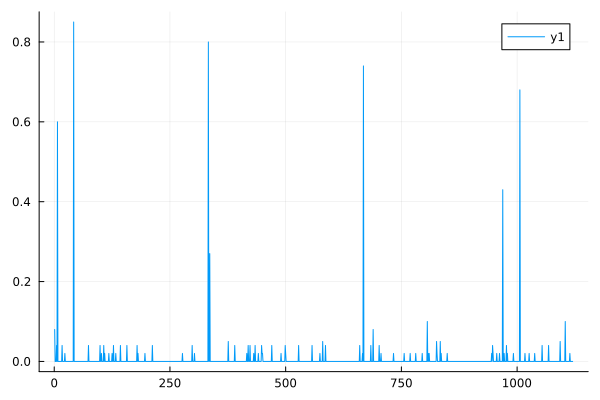

In [101]:
plot(udat)

In [149]:
# define initial parameters and model (M/M/1/K queue)
env = SymbolicEnv()
@bind env begin
    lambda = 0.5
    mu = 1.0
end
model = ctmc(queue(lambda=lambda, mu=mu, K=20))

"CTMCModel(5038280541133922852)"

In [150]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model, env, udat, 0.9, 0.1, verbose = false) # if you want to print LLFs in the algorithm, set verbose = true

(params = Dict{Symbol, Any}(:lambda => 0.5741921472597752, :mu => 30.817625795633404), llf = -94.27404572992911, conv = true, iter = 101, aerror = 9.265636604993688e-5, rerror = 9.828397017034582e-7)

In [151]:
# estimated lambda and mu
seval(lambda, env), seval(mu, env)

(0.5741921472597752, 30.817625795633404)

In [152]:
# define initial parameters and model (M/M/1/K queue) in the case where mu is fixed
env = SymbolicEnv()
@bind env begin
    lambda = 0.5
end
model = ctmc(queue(lambda=lambda, mu=1.0, K=20))

"CTMCModel(15578527667108800915)"

In [153]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model, env, udat, 0.9, 0.1, verbose = false) # if you want to print LLFs in the algorithm, set verbose = true

(params = Dict{Symbol, Any}(:lambda => 0.10442969324563052), llf = -254.14311653669657, conv = true, iter = 9, aerror = 2.6427662191963464e-5, rerror = 1.0398731157452358e-7)

In [154]:
# estimated lambda
seval(lambda, env)

0.10442969324563052

In [155]:
# Define MMPP/M/1/K queue in QBD; nphase denotes the number of phases of MMPP
nphase = 2
b0 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a0 = [(i == j) ? symbolic(@s("lambda_$i$j")) : 0 for i = 1:nphase, j = 1:nphase]
a1 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a2 = [(i == j) ? symbolic(@s("mu")) : 0 for i = 1:nphase, j = 1:nphase]
tmp0 = [v.var for v = b0 if typeof(v) <: SymbolicVariable]
tmp1 = [v.var for v = a0 if typeof(v) <: SymbolicVariable]
tmp2 = [v.var for v = a1 if typeof(v) <: SymbolicVariable]
tmp3 = [v.var for v = a2 if typeof(v) <: SymbolicVariable]
env2 = SymbolicEnv([x=>rand() for x = [tmp0..., tmp1..., tmp2..., tmp3...]])
model2 = ctmc(queue2(B0=b0, A0=a0, A1=a1, A2=a2, K=20))

"CTMCModel(3391693416423967468)"

In [156]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model2, env2, udat, 0.9, 0.1, verbose = false) # if you want to print LLFs in the algorithm, set verbose = true

(params = Dict{Symbol, Any}(:lambda_22 => 0.4175052680131304, :mu => 30.863048486323112, :lambda_11 => 0.580738650625684, :beta_21 => 0.6523258530627362, :beta_12 => 0.02571929760502324), llf = -94.27574249909961, conv = true, iter = 107, aerror = 9.040653726799519e-5, rerror = 9.589577146296383e-7)

In [157]:
# B0 (ignore the diagonal elements)
[(typeof(x) <: Number) ? x : seval(x, env2) for x = b0]

2×2 Matrix{Real}:
 0         0.0257193
 0.652326  0

In [158]:
# A0
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a0]

2×2 Matrix{Real}:
 0.580739  0
 0         0.417505

In [159]:
# A1 (ignore the diagonal elements)
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a1]

2×2 Matrix{Real}:
 0         0.0257193
 0.652326  0

In [160]:
# A2
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a2]

2×2 Matrix{Real}:
 30.863   0
  0      30.863

In [161]:
# Define MMPP/M/1/K queue in QBD; nphase denotes the number of phases of MMPP in the case where mu is fixed
nphase = 2
b0 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a0 = [(i == j) ? symbolic(@s("lambda_$i$j")) : 0 for i = 1:nphase, j = 1:nphase]
a1 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a2 = [(i == j) ? 1.0 : 0 for i = 1:nphase, j = 1:nphase]
tmp0 = [v.var for v = b0 if typeof(v) <: SymbolicVariable]
tmp1 = [v.var for v = a0 if typeof(v) <: SymbolicVariable]
tmp2 = [v.var for v = a1 if typeof(v) <: SymbolicVariable]
tmp3 = [v.var for v = a2 if typeof(v) <: SymbolicVariable]
env2 = SymbolicEnv([x=>rand() for x = [tmp0..., tmp1..., tmp2..., tmp3...]]) # initial values are determined as random values
model2 = ctmc(queue2(B0=b0, A0=a0, A1=a1, A2=a2, K=20))

"CTMCModel(6163707510435879295)"

In [162]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model2, env2, udat, 0.9, 0.1, verbose = false) # if you want to print LLFs in the algorithm, set verbose = true

(params = Dict{Symbol, Any}(:lambda_22 => 0.09861727158282646, :lambda_11 => 0.1269719516732555, :beta_21 => 0.2269940619310607, :beta_12 => 0.8865669489676643), llf = -254.10726173304224, conv = true, iter = 38, aerror = 0.0002300501861043358, rerror = 9.053262636608325e-7)

In [163]:
# B0 (ignore the diagonal elements)
[(typeof(x) <: Number) ? x : seval(x, env2) for x = b0]

2×2 Matrix{Real}:
 0         0.886567
 0.226994  0

In [164]:
# A0
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a0]

2×2 Matrix{Real}:
 0.126972  0
 0         0.0986173

In [165]:
# A1 (ignore the diagonal elements)
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a1]

2×2 Matrix{Real}:
 0         0.886567
 0.226994  0

In [166]:
# A2
[(typeof(x) <: Number) ? x : seval(x, env2) for x = a2]

2×2 Matrix{Real}:
 1.0  0
 0    1.0